In [1]:
import pysal as ps
import pandas as pd
import numpy as np

A well-used functionality in PySAL is the use of PySAL to conduct exploratory spatial data analysis. This notebook will provide an overview of ways to conduct exploratory spatial analysis in Python. 

First, let's read in some data:

In [6]:
data = ps.pdio.read_files(ps.examples.get_path('NAT.shp'))
W = ps.queen_from_shapefile(ps.examples.get_path('NAT.shp'))
W.transform = 'r'

In [5]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lake of the Woods,Minnesota,27,077,27077,27,77,27077,0,0.000000,...,0.024534,0.285235,0.372336,0.342104,0.336455,11.279621,5.4,5.663881,9.515860,<pysal.cg.shapes.Polygon object at 0x7f952add5...
1,Ferry,Washington,53,019,53019,53,19,53019,0,0.000000,...,0.317712,0.256158,0.360665,0.361928,0.360640,10.053476,2.6,10.079576,11.397059,<pysal.cg.shapes.Polygon object at 0x7f952add5...
2,Stevens,Washington,53,065,53065,53,65,53065,0,1.863863,...,0.210030,0.283999,0.394083,0.357566,0.369942,9.258437,5.6,6.812127,10.352015,<pysal.cg.shapes.Polygon object at 0x7f952ad05...
3,Okanogan,Washington,53,047,53047,53,47,53047,0,2.612330,...,0.155922,0.258540,0.371218,0.381240,0.394519,9.039900,8.1,10.084926,12.840340,<pysal.cg.shapes.Polygon object at 0x7f952ad05...
4,Pend Oreille,Washington,53,051,53051,53,51,53051,0,0.000000,...,0.134605,0.243263,0.365614,0.358706,0.387848,8.243930,4.1,7.557643,10.313002,<pysal.cg.shapes.Polygon object at 0x7f952ad05...


In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in `HR90` we could quickly compute a Moran's $I$ statistic:

In [7]:
I_HR90 = ps.Moran(data.HR90.values, W)

In [16]:
I_HR90.I, I_HR90.p_sim

(0.38331361120633289, 0.001)

Thus, the $I$ statistic is $.383$ for this data, and has a very small $p$ value. 

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [27]:
I_HR90.sim[0:5]

array([-0.00352289,  0.00930096, -0.00695237, -0.00640295, -0.00164303])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

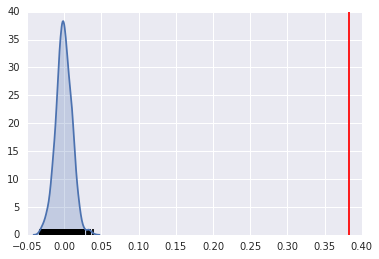

In [38]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 1)
plt.vlines(I_HR90.I, 0, 40, 'r')

Instead, if our $I$ statistic were close to our expected value, `I_HR90.EI`, our plot might look like this:

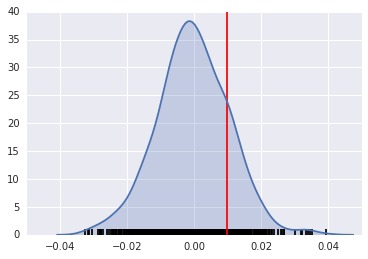

In [37]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 1)
plt.vlines(I_HR90.EI+.01, 0, 40, 'r')

In addition to univariate Moran's $I$, PySAL provides many other types of autocorrelation statistics:

In [18]:
c_HR90 = ps.Geary(data.HR90.values, W)
#ps.Gamma
#ps.Join_Counts

In [21]:
c_HR90.C, c_HR90.p_sim

(0.6014702718685413, 0.001)

Since the statistic is below one with a significant $p$-value, it indicates the same thing as the Moran's $I$ above, moderate significant global spatial dependence in `HR90`. 

In addition, we can compute a global Bivariate Moran statistic, which relates an observation to the spatial lag of another observation:

In [23]:
bv_HRBLK = ps.Moran_BV(data.HR90.values, data.BLK90.values, W)

In [24]:
bv_HRBLK.I, bv_HRBLK.p_sim

(0.45543251212989283, 0.001)

### Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [39]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [41]:
LMo_HR90.Is, LMo_HR90.p_sim

(array([ 0.25979475, -0.37319832,  0.00470282, ..., -0.19815194,
         0.18971775,  0.20310378]),
 array([ 0.368,  0.389,  0.363, ...,  0.08 ,  0.129,  0.135]))

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [58]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [59]:
Lag_HR90 = ps.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [81]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [95]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

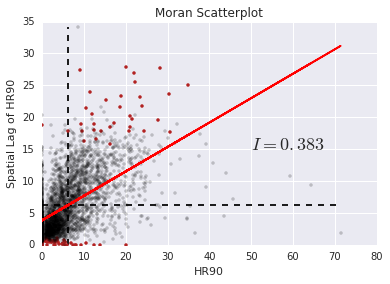

In [100]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

### Simple exploratory regression

Sometimes, to check for simple spatial heterogeneity, a fixed effects model can be estimated.  If the heterogeneity has known bounds. First, though, note that `pandas` can build dummy variable matrices from categorical data very quickly:

In [296]:
pd.get_dummies(data.SOUTH) #dummies for south (already binary)

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


Where this becomes handy is if you have data you know can be turned into a dummy variable, but is not yet correctly encoded. 

For example, the same call as above can make a dummy variable matrix to encode state fixed effects using the `STATE_NAME` variable:

In [297]:
pd.get_dummies(data.STATE_NAME) #dummies for state by name

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For now, let's estimate a spatial regimes regression on the south/not-south division. To show how a regimes effects plot may look, let's consider one covariate that is likely related and one that is very likely unrelated to $y$. That is our formal specification for the regression will be:

$$ y = \beta_{0} + x_{1a}\beta_{1a} + x_{1b}\beta_{1b} + x_{2}\beta_{2} + \epsilon $$

Where $x_{1a} = 1$ when an observation is not in the south, and zero when it is not. This is a simple spatial fixed effects setup, where each different spatial unit is treated as having a special effect on observations inside of it. 

In addition, we'll add an unrelated term to show how the regression effects visualization works:

In [325]:
y = data[['HR90']].values
x = data[['BLK90']].values

unrelated_effect = np.random.normal(0,100, size=y.shape[0]).reshape(y.shape)

X = np.hstack((x, unrelated_effect))

regimes = data.SOUTH.values.tolist()

In [326]:
regime_reg = ps.spreg.OLS_Regimes(y, X, regimes)

In [329]:
betas = regime_reg.betas
sebetas = np.sqrt(regime_reg.vm.diagonal())

In [330]:
sebetas

array([ 0.11097482,  0.0243957 ,  0.00103073,  0.22238443,  0.00918036,
        0.0016358 ])

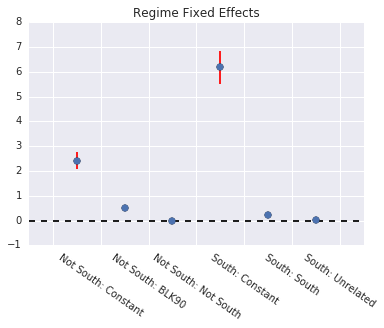

In [335]:
plt.plot(betas,'ok')
plt.axis([-1,6,-1,8])
plt.hlines(0,-1,6, color='k', linestyle='--')
plt.errorbar([0,1,2,3,4,5], betas.flatten(), yerr=sebetas*3, fmt='o', ecolor='r')
plt.xticks([-.5,0.5,1.5,2.5,3.5,4.5, 5.5], ['',
                                       'Not South: Constant',
                                       'Not South: BLK90',
                                       'Not South: Not South',
                                       'South: Constant',
                                       'South: South',
                                       'South: Unrelated',''], rotation='325')
plt.title('Regime Fixed Effects')